In [1]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

start_datetime = datetime.datetime.strptime("2022-03-10 00:00:00", "%Y-%m-%d %H:%M:%S")
end_datetime = datetime.datetime.strptime("2018-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
target_coin = "FX_BTC_JPY"


ohlc_list=[]
while start_datetime > end_datetime:
    unixtime = start_datetime.timestamp() * 1000
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    start_datetime -= timedelta(minutes=720)
    time.sleep(1)


df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)
display(df_1m)

df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

In [2]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
rule = "60T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-01-01 00:00:00+00:00,1884160.0,1889892.0,1864120.0,1867622.0,1877.843963
2018-01-01 01:00:00+00:00,1867622.0,1881998.0,1831950.0,1833922.0,2911.988771
2018-01-01 02:00:00+00:00,1833922.0,1850000.0,1829020.0,1843084.0,1997.209876
2018-01-01 03:00:00+00:00,1843084.0,1864499.0,1839690.0,1853000.0,1500.046339
2018-01-01 04:00:00+00:00,1853000.0,1868600.0,1842673.0,1865800.0,1169.399265
...,...,...,...,...,...
2022-03-09 20:00:00+00:00,4957879.0,4970599.0,4895601.0,4911349.0,215.869494
2022-03-09 21:00:00+00:00,4911872.0,4931781.0,4894578.0,4922094.0,212.283162
2022-03-09 22:00:00+00:00,4922305.0,4943060.0,4905329.0,4925051.0,167.617289


In [3]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-01-01 00:00:00+00:00,1884160.0,1889892.0,1864120.0,1867622.0,1877.843963,0.0
2018-01-01 01:00:00+00:00,1867622.0,1881998.0,1831950.0,1833922.0,2911.988771,0.0
2018-01-01 02:00:00+00:00,1833922.0,1850000.0,1829020.0,1843084.0,1997.209876,0.0
2018-01-01 03:00:00+00:00,1843084.0,1864499.0,1839690.0,1853000.0,1500.046339,0.0
2018-01-01 04:00:00+00:00,1853000.0,1868600.0,1842673.0,1865800.0,1169.399265,0.0
...,...,...,...,...,...,...
2022-03-09 20:00:00+00:00,4957879.0,4970599.0,4895601.0,4911349.0,215.869494,0.0
2022-03-09 21:00:00+00:00,4911872.0,4931781.0,4894578.0,4922094.0,212.283162,0.0
2022-03-09 22:00:00+00:00,4922305.0,4943060.0,4905329.0,4925051.0,167.617289,0.0


In [4]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    # 追加
    df['MIDPRICE'] = talib.MIDPRICE(high, low, timeperiod=14)
    df['SAR'] = talib.SAR(high, low, acceleration=0, maximum=0)
    df['SAREXT'] = talib.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CMO'] = talib.CMO(close, timeperiod=14)
    df['MACDEXT_macd'], df['MACDEXT_macdsignal'], df['MACDEXT_macdhist'] = talib.MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
    df['MACDFIX_macd'], df['MACDFIX_macdsignal'], df['MACDFIX_macdhist'] = talib.MACDFIX(close, signalperiod=9)
    df['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    df['ROC'] = talib.ROC(close, timeperiod=10)
    df['ROCP'] = talib.ROCP(close, timeperiod=10)
    df['ROCR'] = talib.ROCR(close, timeperiod=10)
    df['ROCR100'] = talib.ROCR100(close, timeperiod=10)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['AVGPRICE'] = talib.AVGPRICE(open, high, low, close)
    df['MEDPRICE'] = talib.MEDPRICE(high, low)
    df['TYPPRICE'] = talib.TYPPRICE(high, low, close)
    df['WCLPRICE'] = talib.WCLPRICE(high, low, close)

    df['CDLADVANCEBLOCK'] = talib.CDLADVANCEBLOCK(open, high, low, close)
    df['CDLBELTHOLD'] = talib.CDLBELTHOLD(open, high, low, close)
    df['CDLHAMMER'] = talib.CDLHAMMER(open, high, low, close)
    df['CDLHARAMICROSS'] = talib.CDLHARAMICROSS(open, high, low, close)
    
    df['TSF'] = talib.TSF(close, timeperiod=14)
    df['VAR'] = talib.VAR(close, timeperiod=5, nbdev=1)
    
#    df['ACOS'] = talib.ACOS(close)
#    df['ASIN'] = talib.ASIN(close)
#    df['ATAN'] = talib.ATAN(close)
#    df['CEIL'] = talib.CEIL(close)
#    df['COS'] = talib.COS(close)
#    df['COSH'] = talib.COSH(close)
#    df['EXP'] = talib.EXP(close)
#    df['FLOOR'] = talib.FLOOR(close)
#    df['LN'] = talib.LN(close)
#    df['LOG10'] = talib.LOG10(close)
#    df['SIN'] = talib.SIN(close)
#    df['SINH'] = talib.SINH(close)
#    df['SQRT'] = talib.SQRT(close)
#    df['TAN'] = talib.TAN(close)
#    df['TANH'] = talib.TANH(close)

#    df['ADD'] = talib.ADD(high, low)
#    df['DIV'] = talib.DIV(high, low)
#    df['MAX'] = talib.MAX(close, timeperiod=30)
#    df['MAXINDEX'] = talib.MAXINDEX(close, timeperiod=30)
#    df['MIN'] = talib.MIN(close, timeperiod=30)
#    df['MININDEX'] = talib.MININDEX(close, timeperiod=30)
#    df['MINMIN'], df['MAXMAX'] = talib.MINMAX(close, timeperiod=30)
#    df['minidx'], df['maxidx'] = talib.MINMAXINDEX(close, timeperiod=30)
#    df['MULT'] = talib.MULT(high, low)
#    df['SUB'] = talib.SUB(high, low)
#    df['SUM'] = talib.SUM(close, timeperiod=30)
    
    
    

    
    return df

df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('df_bf_fx_features.pkl')

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,CDLADVANCEBLOCK,CDLBELTHOLD,CDLHAMMER,CDLHARAMICROSS,TSF,VAR
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,1884160.0,1889892.0,1864120.0,1867622.0,1877.843963,0.0,NaN,NaN,NaN,NaN,...,1876448.50,1877006.0,1.873878e+06,1872314.00,0,0,0,0,NaN,NaN
2018-01-01 01:00:00+00:00,1867622.0,1881998.0,1831950.0,1833922.0,2911.988771,0.0,NaN,NaN,NaN,NaN,...,1853873.00,1856974.0,1.849290e+06,1845448.00,0,0,0,0,NaN,NaN
2018-01-01 02:00:00+00:00,1833922.0,1850000.0,1829020.0,1843084.0,1997.209876,0.0,NaN,NaN,NaN,NaN,...,1839006.50,1839510.0,1.840701e+06,1841297.00,0,0,0,0,NaN,NaN
2018-01-01 03:00:00+00:00,1843084.0,1864499.0,1839690.0,1853000.0,1500.046339,0.0,NaN,NaN,NaN,NaN,...,1850068.25,1852094.5,1.852396e+06,1852547.25,0,0,0,0,NaN,NaN
2018-01-01 04:00:00+00:00,1853000.0,1868600.0,1842673.0,1865800.0,1169.399265,0.0,22963.509693,-2950.9,-28865.309693,NaN,...,1857518.25,1855636.5,1.859024e+06,1860718.25,0,0,0,0,NaN,1.678892e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-09 20:00:00+00:00,4957879.0,4970599.0,4895601.0,4911349.0,215.869494,0.0,55425.967599,13427.6,-28570.767599,32380.807682,...,4933857.00,4933100.0,4.925850e+06,4922224.50,0,0,0,0,4.952580e+06,4.409657e+08
2022-03-09 21:00:00+00:00,4911872.0,4931781.0,4894578.0,4922094.0,212.283162,0.0,67546.573192,25308.3,-16929.973192,55933.747156,...,4915081.25,4913179.5,4.916151e+06,4917636.75,0,0,0,0,4.940745e+06,4.460179e+08
2022-03-09 22:00:00+00:00,4922305.0,4943060.0,4905329.0,4925051.0,167.617289,0.0,36316.908613,5705.1,-24906.708613,48271.134886,...,4923936.25,4924194.5,4.924480e+06,4924622.75,0,0,0,0,4.934558e+06,2.342707e+08


In [5]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
    
#    'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
#追加
#    'MIDPRICE',
#    'SAR',
#    'SAREXT',
    'BOP',
#    'CMO',
#    'MACDEXT_macd',
#    'MACDEXT_macdsignal',
#    'MACDEXT_macdhist',
#    'MACDFIX_macd',
#    'MACDFIX_macdsignal',
#    'MACDFIX_macdhist',
#    'PPO',
    'ROC',
    'ROCP',
#    'ROCR',
#    'ROCR100',
    'STOCHF_fastd',
#    'STOCHRSI_fastk',
#    'STOCHRSI_fastd',
#    'TRIX',
#    'AD',
#    'ADOSC',
#    'OBV',
#    'NATR',
#    'TRANGE',
#    'AVGPRICE',
#    'MEDPRICE',
#    'TYPPRICE',
#    'WCLPRICE',
#    'HT_SINE_sine',
#    'HT_SINE_leadsine',

    'CDLADVANCEBLOCK',
    'CDLBELTHOLD',
    'CDLHAMMER',
    'CDLHARAMICROSS',
    
#    'TSF',
#    'VAR',
    
#    'ACOS',  
#    'ASIN',
#    'ATAN'
#    'CEIL',
#    'COS',
#    'COSH',
#    'EXP',
#    'FLOOR',
#    'LN',
#    'LOG10'
#    'SIN'
#    'SINH'
#    'SQRT'
#    'TAN'
#    'TANH'
#    'ADD',
#    'DIV',
#    'MAX',
#    'MAXINDEX'
#    'MIN',
#    'MININDEX',
#    'MINMIN',
#    'MAXMAX',
#    'minidx',
#    'maxidx',
#    'MULT',
#    'SUB',
#    'SUM',
    
    
    
    
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'BOP', 'CCI', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLHAMMER', 'CDLHARAMICROSS', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'ROC', 'ROCP', 'RSI', 'STDDEV', 'STOCHF_fastd', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


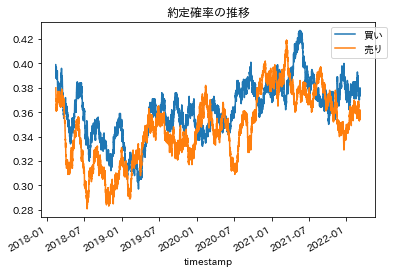

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


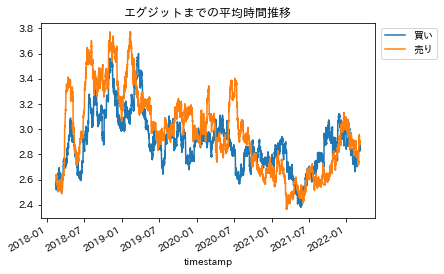

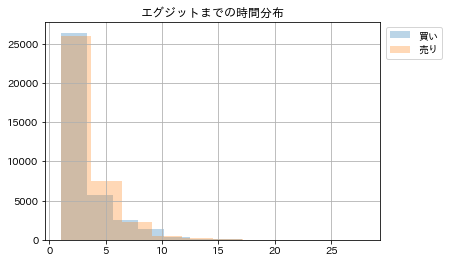

毎時刻、この執行方法でトレードした場合の累積リターン


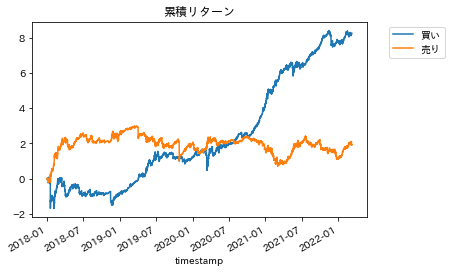

In [6]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_y.pkl')

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


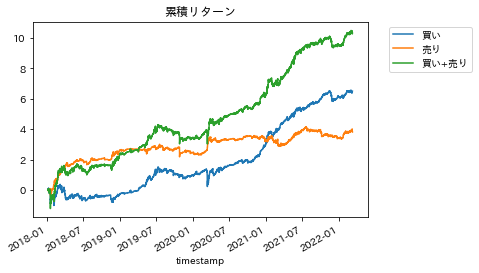

In [7]:
df = pd.read_pickle('df_bf_fx_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell_bffx.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_fit.pkl')

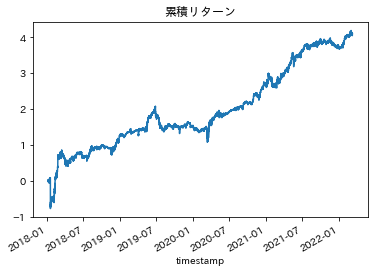

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


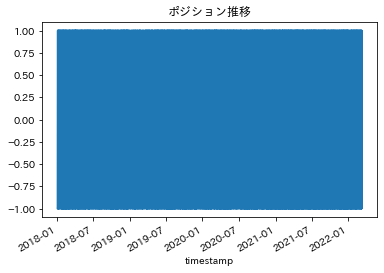

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


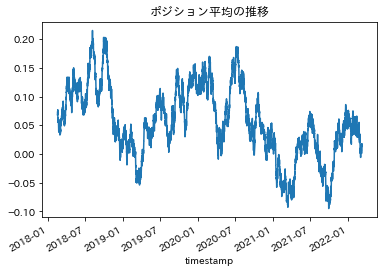

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


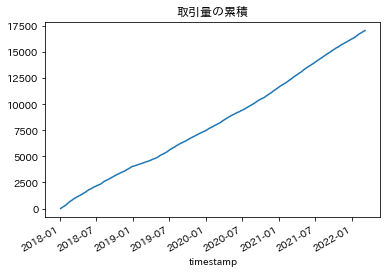

t検定
t値 2.6385130799992274
p値 0.008330579146676724
p平均法 n = 5
p平均 0.290351331274354
エラー率 0.053738790038599125


In [8]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))